## Data description
The provided data set consists of two files (product.csv and weather.csv with link provided below). 

The products.csv data set contains synthetic (i.e. manipulated data to represent the real world) 1-min resampled information on day-ahead* contracts on natural gas between Sep 2020 and Oct 2022. It covers six different locations in continental Europe. Data is represented as an OHLCV object**, where O = Open, H = High, L = Low, C = Close, V = Volume. We include a time series of volume in MW and another where it has been translated into total MWh (by multiplying with 24). 

The weather.csv data set contains synthetic forecasts on a large set of weather related variables (e.g. temperature, humidity, cloud cover, wind speed) across numerous places in Europe.*** You can find additional details by searching in the upper right corner of this link: https://apps.ecmwf.int/codes/grib/param-db/. Forecasts are generated four times a day for the following 10 days ahead (at 0:00, 6:00, 12:00, and 18:00 UTC). All time stamps have been converted into CET, for comparability with the products.csv data, and an DateTime_avail is included to indicate the time at which a given forecast is actually available to the consumer. The step column indicate the time delta to the forecast time (DateTime column) from which the forecast applies. For instance, for temperature (variable 2t), step equal to 1 days 09:00:00 indicates that the value provides a forecast 1 day and nine hours later than DateTime (not DateTime_avail). 

Country codes are provided below. For convenience and to mitigate potential issues with memory, data is also saved in .feather format. The full data set is also split into smaller .csv files (per region, cf. description below).

*Note: A natural gas day-ahead contract promises physical delivery the next business day, starting from 6:00 CET until 6:00 CET the following day (i.e. 24 hours). It is quoted in EUR/MWh - the price that applies to all 24 hours the day-ahead contract covers. Five traded MW day-ahead contract (120MWh) at price 100 EUR/MWh thus have a nominal value of 12,000EUR. 

**Note: OHLCV is a typical way of representating a large set of individual (tick) trades on a given product. It is heavily used by traders in charts, cf. this intro page https://en.wikipedia.org/wiki/Open-high-low-close_chart, but it is too a useful representation for subsequent modeling. 

***Note: Weather can be a major driver of energy prices. In the context of gas, demand is for instance dependent on the need for heating or power generation, both for households and the industry. 

## Your tasks
Given the provided data set, your task is to continue the work in this notebook. The goal of the work is to facilitate a technical/academic conversation, not to be a final research piece. We will discuss both the analytical aspects as well as the software (with an eye towards production code suitability). Reasoning is important. 

#### 
1. Build one (or more) class(es) or function(s) that create(s) a trading strategy. The code should be autonomous in the sense that if we were to submit a new data set of the same format (e.g. with updated values) it would still function and provide new (updated) results. 
You may choose to trade in one or several locations up to your liking. A reasonal maximum exposure of your portfolio is 200MW day-ahead (the equivalent of 200*24=4800MWh). In your solution, make sure to: 
* to illustrate and interpret relevant data/findings throughout the case.
* to quantitatively evaluate the performance of your trading strategy. There are many metrics which can be used to evaluate a strategy. Pick the ones you find relevant for the strategy that you have designed. If you form predictions of day-ahead prices of sorts, consider quantitatively evaluating them in isolation, too. 
* keep in mind compute time and efficiency of your code. 

#### Instructions
* Please present your work in a self-sufficient notebook and constrain any additional external libraries to those that can be simply pip installed. Use comments/markdowns where appropriate.
* Send your notebook no later than January 19 at midnight CET to Daniel Borup Andersen (dab@in-commodities.com), Mikkel Slot Nielsen (msn@in-commodities.com) and Christian Gøbel Bach (chc@in-commodities.com).
* You are welcome to contact Daniel in need of clarification of case tasks or if practical issues with data arise. 

The work is expected to take no more than four-five hours. Have fun!

#### Links to data

Link to data: 
https://incommodities-my.sharepoint.com/:f:/g/personal/dab_in-commodities_com/EjQd_Y4a_WpEjrhvw7t_QcsBVCdd2DEJvINuIFSCAUsJag?email=laegsgaardtroels%40gmail.com&e=43hvk7

Log in with your email address.

## Requirements
* python>=3.9
* pandas>=1.3.5


## Importing Packages and Loading Data

In [30]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bokeh.io import output_notebook
from bokeh import layouts
from bokeh.plotting import show

import visualize

output_notebook()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading BokehJS ...

Loading the data, when data is being loaded it is automatically being cast by numpy from (UTC+2:00) to UTC timezone since the datetimes in the products datasets have the format `2020-09-24 08:01:00+02:00`, not being cast from CET (UTC+01:00).

In [2]:
# utils.py

# Could be in a yaml config file.
config = {
    "data_dir": "/Users/troelslaegsgaard/Git/incommodities_case/data/"
}

def load_products(market, data_dir=config["data_dir"]):
    return np.genfromtxt(
        f'{data_dir}/products_{market}.csv',
        delimiter=',',
        dtype=[
            ("timestamp", "datetime64[s]"),
            ("open", "<f8"),
            ("high", "<f8"),
            ("low", "<f8"),
            ("close", "<f8"),
            ("volume", "<f8"),
            ("volume_mwh", "<f8"),
            ("region", "|U2"),  
        ],
        skip_header=1,
    )


def load_weather(market, data_dir=config["data_dir"]):
    return np.genfromtxt(
        f'{data_dir}/weather_{market}.csv',
        delimiter=',',
        dtype=[
            ("timestamp_avail", "datetime64[s]"),
            ("step", "timedelta64[s]"),
            ("timestamp", "datetime64[s]"),
            ("region", "|U2"),
            ("10u", "<f8"),
            ("10v", "<f8"),
            ("2d", "<f8"),
            ("2r", "<f8"),
            ("2t", "<f8"),
            ("dlwrf", "<f8"),
            ("dswrf", "<f8"),
            ("sp", "<f8"),
            ("tcc", "<f8"),
            ("tp", "<f8"),
        ],
        skip_header=1,
    )

### Sanity Checks

Check that all timestamps match for each product.

In [4]:
products_at = load_products("at")
products_be = load_products("be")
products_de = load_products("de")
products_dk = load_products("dk")
products_fr = load_products("fr")
products_nl = load_products("nl")

In [5]:
t = products_at["timestamp"]
assert np.all(t == products_be["timestamp"])
assert np.all(t == products_de["timestamp"])
assert np.all(t == products_dk["timestamp"])
assert np.all(t == products_fr["timestamp"])
assert np.all(t == products_nl["timestamp"])

Check that the data is ~2 years.

In [6]:
print(np.min(t), np.max(t)) 

2020-09-24T06:01:00 2022-10-19T16:00:00


Check sampling frequency. It looks like the data is sampled with 60 seconds difference or difference according to open/close time of the market.

In [7]:
dt = (t[1:] - t[:-1]).astype("int64")
unique, counts = np.unique(dt, return_counts=True)
pd.DataFrame({"dt [s]": unique, "count": counts})

,dt [s],count
0,60,319267
1,50460,424
2,219660,2
3,223260,99
4,226860,2
5,309660,3
6,396060,2


In [8]:
pdf = pd.DataFrame(products_at)
pdf["hour"] = pdf["timestamp"].dt.hour
pdf.groupby("hour").size()

hour
6     18939
7     31768
8     31980
9     31980
10    31980
11    31980
12    31980
13    31980
14    31980
15    31980
16    13041
17      212
dtype: int64

# Bokeh Data Visualization

Small bokeh sample visualizations to gain some intuition.

It looks like the prices for many regions is constant in the morning and more volatile at the end of the day.

In [25]:
sample = products_at[-60*10*3:]  # ~3 days
fig = visualize.candlesticks(sample)
show(fig)

In [26]:
figs = []
for product in [products_at, products_be, products_de, products_dk, products_fr, products_nl]:
    sample = product[-60*10*3:]
    fig = visualize.candlesticks(sample)
    figs.append(fig)
for fig in figs[1:]:
    fig.children[0].x_range = figs[0].children[0].x_range
show(layouts.column(children=figs))

## Analyze Correlations

I would assume the prices should be correlated across regions since it is the same underlying commodity.

In [45]:
data = {}
for market in ["at", "be", "de", "dk", "fr", "nl"]:
    products = load_products(market)
    data.update({f"open_{ohlcv}": products["open"]})
pdf = pd.DataFrame(data)

In [46]:
display(pdf.corr())

,at_open,be_open,de_open,dk_open,fr_open,nl_open
at_open,1.000000,0.959035,0.998993,0.997219,0.950416,0.998780
be_open,0.959035,1.000000,0.959370,0.958710,0.988789,0.959510
de_open,0.998993,0.959370,1.000000,0.997201,0.950615,0.999624
dk_open,0.997219,0.958710,0.997201,1.000000,0.949936,0.996923
fr_open,0.950416,0.988789,0.950615,0.949936,1.000000,0.950846
nl_open,0.998780,0.959510,0.999624,0.996923,0.950846,1.000000


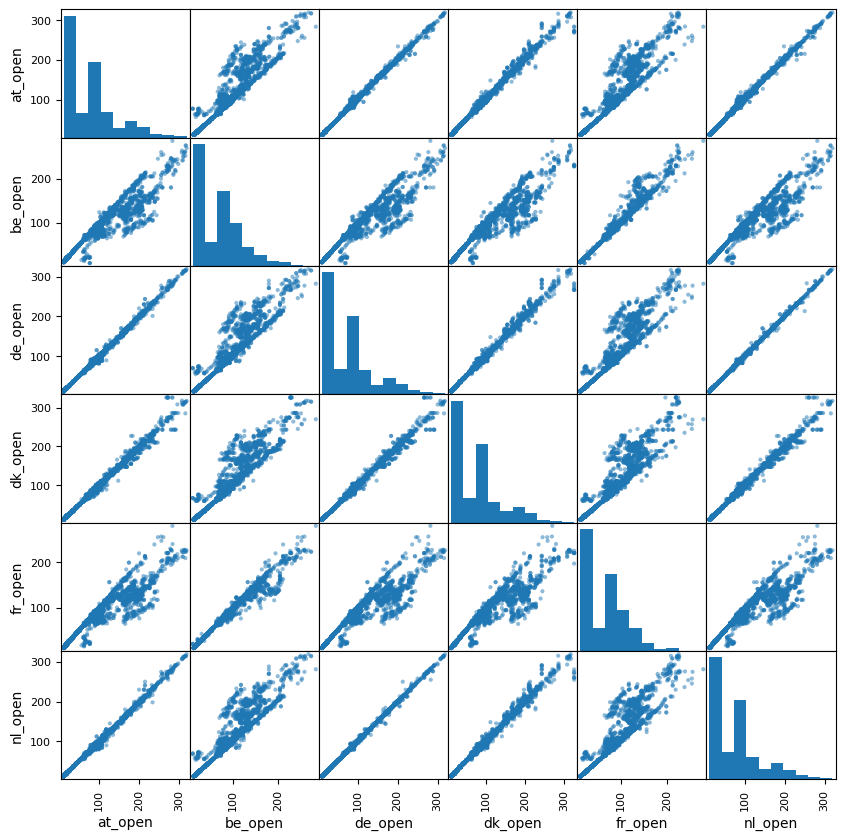

In [58]:
_ = pd.plotting.scatter_matrix(pdf.sample(5000), figsize=(10, 10))

It looks like the regions: fr and be is less linearly correlated with the regions: de, at, dk, nl.

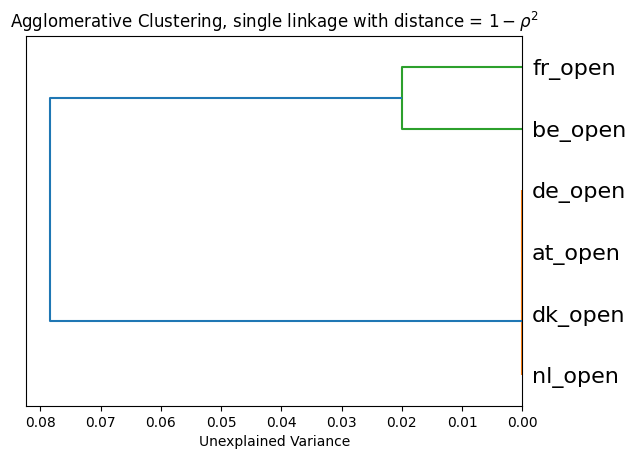

In [52]:
from scipy.cluster import hierarchy as hc


def correlation_dendogram(df, method='single'):
    """Used to plot the dendogram from a correlation matrix.
    
    1 - corr ** 2 can be interpreted as the unexplained variance
    from a linear model between a bivariate distribution (X, Y).
    This can be interpreted as a distance matrix and used in a
    clustering method.
    """
    plt.figure()
    corr = df.corr()
    corr = np.round(corr, 2)
    distance_matrix = 1 - corr ** 2
    corr_condensed = hc.distance.squareform(distance_matrix)
    z = hc.linkage(corr_condensed, method=method)
    hc.dendrogram(
        z,
        labels=corr.columns,
        orientation='left',
        leaf_font_size=16,
    )
    plt.title(
        "Agglomerative Clustering, single linkage with "
        "distance = $1 - \\rho^2$"
    )
    plt.xlabel(
        "Unexplained Variance"
    )
    plt.show()
    
correlation_dendogram(pdf)

# Basic Trading Agent

To build a trading agent it would make sense to draw some inspiration from David Silvers lecture notes and the book: Reinforcement Learning: An Introduction by Richard S. Sutton and Andrew G. Barto. Not necessary because one should use reinforcement learning, but the abstractions used are pretty general and can also be used in dynamic programming (value and policy iteration). Plus it seems like an idea to try and combine a state-action-value function with arbitrage free pricing or similar tools from mathematical finance.

A central mathematical abstraction is the Markov Decision Process which models the interaction between an agent and the environment and the constant sequence of `state_0, action_0, reward_1, state_1, action_1, ...`.

Two classes I would therefore argue for makes sense is the:

1. `Environment`: Models the transitions $Pr(S_t=s,R_t=r|S_{t−1}=s,A_{t−1}=a)$ . The `Environment` is used to asses how well the agent is performing in an offline setting using the empirical distribution (the plug-in principle)
2. `Agent`: Models the action of the trading agent given a state.

A natural design choice would be to make the `Environment` and `Agent` able to process data in stepwise manner (online) because:

1. Thats how the agent is going to work in a live setting.
2. Memory should then not be an issue when evaluating the agent offline.

In [60]:
# environment.py

class Environment:
    """The environment class emulates the trading environment."""
    
    def __init__(self, markets=("at", "be", "de", "dk", "fr", "nl")):
        self.markets = markets
        self._state_container = np.empty(
            shape=(1,),
            dtype=self.state_dtype
        )

    @property
    def state_dtype(self):
        state_dtype = []
        for market in self.markets:
            state_dtype.extend([
                (f"{market}_agent_position", "<f8"),
                (f"{market}_open", "<f8"),
                (f"{market}_high", "<f8"),
                (f"{market}_low", "<f8"),
                (f"{market}_close", "<f8"),
                (f"{market}_volume", "<f8"),
            ])
        return state_dtype
    
    def step(self, action):
        for market in self.markets:
            self._state_container[f"{market}_agent_position"] = (
                self._state_container[f"{market}_agent_position"]
                + action[f"{market}_agent_trade"]
            )
        try:
            self._step_market()
        except StopIteration as exception:
            raise StopIteration("Environment has no more steps") from exception
        return self._state_container.copy()
    
    def reset(self):
        for product_file in self.product_files:
            product_file.seek(0)
            next(product_file)
        self._step_market()
        for market in self.markets:
            self._state_container[f"{market}_agent_position"] = 0
        return self._state_container.copy()
        
    def _step_market(self):
        for market, product_file in zip(self.markets, self.product_files):
            open, high, low, close, volume = next(product_file).split(",")[1:6]
            self._state_container[f"{market}_open"] = open
            self._state_container[f"{market}_high"] = high
            self._state_container[f"{market}_low"] = low
            self._state_container[f"{market}_close"] = close
            self._state_container[f"{market}_volume"] = volume
        
    def open(self):
        self.product_files = []
        for market in self.markets:
            product_file = open(f"data/products_{market}.csv", "r")
            next(product_file)  # skip header.
            self.product_files.append(product_file)
        
    def close(self):
        for product_file in self.product_files:
            product_file.close()
    
    @property
    def n_steps(self):
        return sum(1 for line in open(f"data/products_{self.markets[0]}.csv", "r")) - 1
    
    def __repr__(self):
        return f"Environment(markets={self.markets})"

In [106]:
# agent.py

import random


class Agent:
    """The trading agent uses its policy to trade in an environment."""
        
    def __init__(self, markets=("at", "be", "de", "dk", "fr", "nl")):
        self.markets = markets
        self._action_container = np.empty(
            shape=(1,),
            dtype=self.action_dtype
        )
        
    @property
    def action_dtype(self):
        action_dtype = []
        for market in self.markets:
            action_dtype.extend([(f"{market}_agent_trade", "<f8")])
        return action_dtype
    
    def policy(self, state):
        raise NotImplementedError("Implement this in subclass")
        
    def __repr__(self):
        return f"{self.__class__.__name__}(markets={self.markets})"


class RandomAgent(Agent):
    """The random trading agent is used for testing purposes (mainly ;-))."""
    
    def policy(self, state):
        for market in self.markets:
            self._action_container[f"{market}_agent_trade"] = random.choice([-1, 1])
        return self._action_container.copy()
    
    
class NaiveAgent(Agent):
    """The naive agent will buy cheap and sell high."""
    
    def __init__(self, markets=("at", "be", "de", "dk", "fr", "nl"), max_exposure_mw=200, mid_price="open_close"):
        super().__init__(markets=markets)
        self.max_exposure_mw = max_exposure_mw
        self.mid_price = mid_price
    
    def policy(self, state):
        mid_prices = {}
        for market in self.markets:
            mid_prices[market] = self.compute_mid(market, state)
        exposure = self.compute_exposure(state, mid_prices)
        
        if exposure > self.max_exposure_mw:
            
        
            self._action_container[f"{market}_agent_trade"] = random.choice([-1, 1])
        return self._action_container.copy()
                  
    def compute_mid(self, market, state):
        if self.mid_price == "open_close":
            return (state[f"{market}_open"] + state[f"{market}_close"]) / 2.
        elif self.mid_price == "high_low":
            return (state[f"{market}_high"] + state[f"{market}_low"]) / 2.
        else:
            raise ValueError(f"Unsupported way of calculating the mid price {mid_price}")
            
    def compute_exposure(self, state, mid_prices):
        exposure = 0
        for market in self.markets:
            exposure += state[f"{market}_agent_position"] * mid_prices[market]
        return exposure        

In [111]:
from tqdm import tqdm


def simulate(environment, agent):
    """Simulate a trading agent.
    
    Args:
        environment (Environment): The environment used during the simulation.
        agent (Agent): The agent one wants to evaluate.
        
    Returns:
        List[Tuple[State, Action]]: A list of all states visited and the action 
            at the given state.
    """
    
    # Preallocate memory.
    state_log = np.empty(shape=(environment.n_steps,), dtype=environment.state_dtype)
    action_log = np.empty(shape=(environment.n_steps,), dtype=agent.action_dtype)
    
    environment.open()
    state = environment.reset()
    for step in tqdm(range(1, environment.n_steps), desc="Simulating trading strategy"):
        action = agent.policy(state)
        state_log[step] = state
        action_log[step] = action
        state = environment.step(action)
    environment.close()
    
    return state_log, action_log

In [112]:
state_log, action_log = simulate(Environment(), agent=RandomAgent())

Simulating trading strategy: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 319799/319799 [00:09<00:00, 33979.24it/s]


In [115]:
action_log

array([(0., 0., 0., 0., 0., 0.), (0., 0., 0., 1., 0., 1.),
       (0., 1., 1., 0., 0., 0.), ..., (1., 1., 0., 0., 1., 0.),
       (0., 0., 1., 1., 1., 1.), (1., 0., 1., 1., 1., 1.)],
      dtype=[('at_agent_trade', '<f8'), ('be_agent_trade', '<f8'), ('de_agent_trade', '<f8'), ('dk_agent_trade', '<f8'), ('fr_agent_trade', '<f8'), ('nl_agent_trade', '<f8')])

In [58]:
states = np.r_[*[state for state, _ in log]]

In [60]:
states

array([(     0., 11.87, 11.87, 11.87, 11.87,  0., 0.00000e+00, 11.41, 11.41, 11.41, 11.41,   7.,      0., 11.64, 11.64, 11.64, 11.64,   0., 0.00000e+00, 11.71, 11.71, 11.71, 11.71, 10.,      0., 11.18, 11.18, 11.18, 11.18,  8., 0.00000e+00, 11.7 , 11.7 , 11.63, 11.63,   0.),
       (     0., 11.87, 11.87, 11.87, 11.87,  0., 0.00000e+00, 11.43, 11.43, 11.43, 11.43,   6.,      0., 11.62, 11.62, 11.62, 11.62,  15., 0.00000e+00, 11.72, 11.72, 11.72, 11.72,  8.,      0., 11.18, 11.18, 11.18, 11.18,  0., 0.00000e+00, 11.7 , 11.7 , 11.63, 11.63,   0.),
       (     0., 11.87, 11.87, 11.87, 11.87,  0., 1.00000e+00, 11.41, 11.41, 11.41, 11.41,   5.,      0., 11.62, 11.62, 11.62, 11.62,   0., 1.00000e+00, 11.72, 11.72, 11.72, 11.72,  0.,      0., 11.13, 11.13, 11.13, 11.13,  6., 1.00000e+00, 11.7 , 11.7 , 11.63, 11.63,   0.),
       ...,
       (159363., 64.97, 64.99, 64.97, 64.99,  0., 1.59996e+05, 35.  , 35.  , 35.  , 35.  ,  14., 160379., 57.01, 57.01, 56.46, 56.61,   0., 1.60044e+05, 65.04, 

# Advanced Trading Agent

In [ ]:
weather_at = load_weather("at")
weather_be = load_weather("be")
weather_de = load_weather("de")
weather_dk = load_weather("dk")
weather_fr = load_weather("fr")
weather_nl = load_weather("nl")